# Prediction notebook  Demo
## StarDist course, Sept 2024

In [1]:
### Inputs
from __future__ import print_function, unicode_literals, absolute_import, division
import os
import sys
import numpy as np
import matplotlib
matplotlib.rcParams["image.interpolation"] = None
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from glob import glob
from tifffile import imread
from csbdeep.utils import Path, normalize
from csbdeep.io import save_tiff_imagej_compatible

from stardist import random_label_cmap, _draw_polygons, export_imagej_rois, gputools_available
from stardist.models import StarDist2D

np.random.seed(6)
lbl_cmap = random_label_cmap()

/tmp/slurm_8869408/ipykernel_69174/2649187474.py:7: MatplotlibDeprecationWarning: Support for setting an rcParam that expects a str value to a non-str value is deprecated since 3.5 and support will be removed two minor releases later.
  matplotlib.rcParams["image.interpolation"] = None
2024-09-05 16:02:30.009034: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


In [2]:
gputools_available()

If you want to compute separable approximations, please install it with
pip install scikit-tensor-py3


True

# Data

We assume that data has already been downloaded in via notebook [1_data.ipynb](1_data.ipynb).  
We now load images from the sub-folder `test` that have not been used during training.

In [3]:
X = sorted(glob('data/dsb2018/test/images/*.tif'))
file_list = []
for name in X:
    file_list.append(os.path.basename(name))
    
X = list(map(imread,X))

n_channel = 1 if X[0].ndim == 2 else X[0].shape[-1]
axis_norm = (0,1)   # normalize channels independently
# axis_norm = (0,1,2) # normalize channels jointly
if n_channel > 1:
    print("Normalizing image channels %s." % ('jointly' if axis_norm is None or 2 in axis_norm else 'independently'))

In [4]:
## Show the filenames
file_list

['0bda515e370294ed94efd36bd53782288acacb040c171df2ed97fd691fc9d8fe.tif',
 '0bf4b144167694b6846d584cf52c458f34f28fcae75328a2a096c8214e01c0d0.tif',
 '1b6044e4858a9b7cee9b0028d8e54fbc8fb72e6c4424ab5b9f3859bfc72b33c5.tif',
 '1c2f9e121fc207efff79d46390df1a740566b683ff56a96d8cabe830a398dd2e.tif',
 '1db1cddf28e305c9478519cfac144eee2242183fe59061f1f15487e925e8f5b5.tif',
 '1f9e429c12f4477221b5b855a5f494fda2ef6d064ff75b061ffaf093e91758c5.tif',
 '2817299fd3b88670e86a9db5651ba24333c299d1d41e5491aabfcd95aee84174.tif',
 '2cfa857e63be1b418c91ad5ea1f8d136fd1b80fc856e1d4277274c3dea28011c.tif',
 '33618678c167c5e07be02c49d0c43bcd90493ba5d83110a631409a4d3ccc1e51.tif',
 '3477024fd843e46097840360f9cdee24b76bf5c593ed27a9aee7a5728a06aa51.tif',
 '3582166ee20755856adf4882a8bfacb616fce4247911605a109c4862de421bcd.tif',
 '3bfd6bb152310f93daa6f4e1867c10572946e874b3a30c9ba8e0fcdeb590300b.tif',
 '43cf6b2ec0b0745ac2b87b4d8780f62e9050d3f5d50a1fcefa42d166191e84c6.tif',
 '4d40de30a3db3bc4f241cb7f48e8497c11e8f20a99bf55788

In [5]:
# show all test images
if False:
    fig, ax = plt.subplots(7,8, figsize=(16,16))
    for i,(a,x) in enumerate(zip(ax.flat, X)):
        a.imshow(x if x.ndim==2 else x[...,0], cmap='gray')
        a.set_title(i)
    [a.axis('off') for a in ax.flat]
    plt.tight_layout()
None;

# Load trained model

If you trained your own StarDist model (and optimized its thresholds) via notebook [2_training.ipynb](2_training.ipynb), then please set `demo_model = False` below.

In [6]:
demo_model = True  ##this is true if the demo model, false if you want to use your own model

if demo_model:
    print (
        "NOTE: This is loading a previously trained demo model!\n"
        "      Please set the variable 'demo_model = False' to load your own trained model.",
        file=sys.stderr, flush=True
    )
    model = StarDist2D.from_pretrained('2D_demo')
else:
    model = StarDist2D(None, name='stardist', basedir='models')
None;

NOTE: This is loading a previously trained demo model!
      Please set the variable 'demo_model = False' to load your own trained model.
2024-09-05 16:02:40.348732: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1


Found model '2D_demo' for 'StarDist2D'.


2024-09-05 16:02:40.359537: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:1e:00.0 name: Tesla V100-SXM2-32GB computeCapability: 7.0
coreClock: 1.53GHz coreCount: 80 deviceMemorySize: 31.74GiB deviceMemoryBandwidth: 836.37GiB/s
2024-09-05 16:02:40.359567: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2024-09-05 16:02:40.369864: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2024-09-05 16:02:40.369912: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublasLt.so.11
2024-09-05 16:02:40.406660: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcufft.so.10
2024-09-05 16:02:40.408880: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcura

Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.486166, nms_thresh=0.5.


## Prediction

Make sure to normalize the input image beforehand or supply a `normalizer` to the prediction function.

Calling `model.predict_instances` will
- predict object probabilities and star-convex polygon distances (see `model.predict` if you want those)
- perform non-maximum suppression (with overlap threshold `nms_thresh`) for polygons above object probability threshold `prob_thresh`.
- render all remaining polygon instances in a label image
- return the label instances image and also the details (coordinates, etc.) of all remaining polygons

In [7]:
img = normalize(X[16], 1,99.8, axis=axis_norm)
labels, details = model.predict_instances(img)

2024-09-05 16:02:42.340221: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2024-09-05 16:02:42.340844: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 2400000000 Hz
2024-09-05 16:02:42.509933: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudnn.so.8
2024-09-05 16:02:43.311719: I tensorflow/stream_executor/cuda/cuda_dnn.cc:359] Loaded cuDNN version 8401
2024-09-05 16:02:44.414691: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2024-09-05 16:02:44.415421: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublasLt.so.11


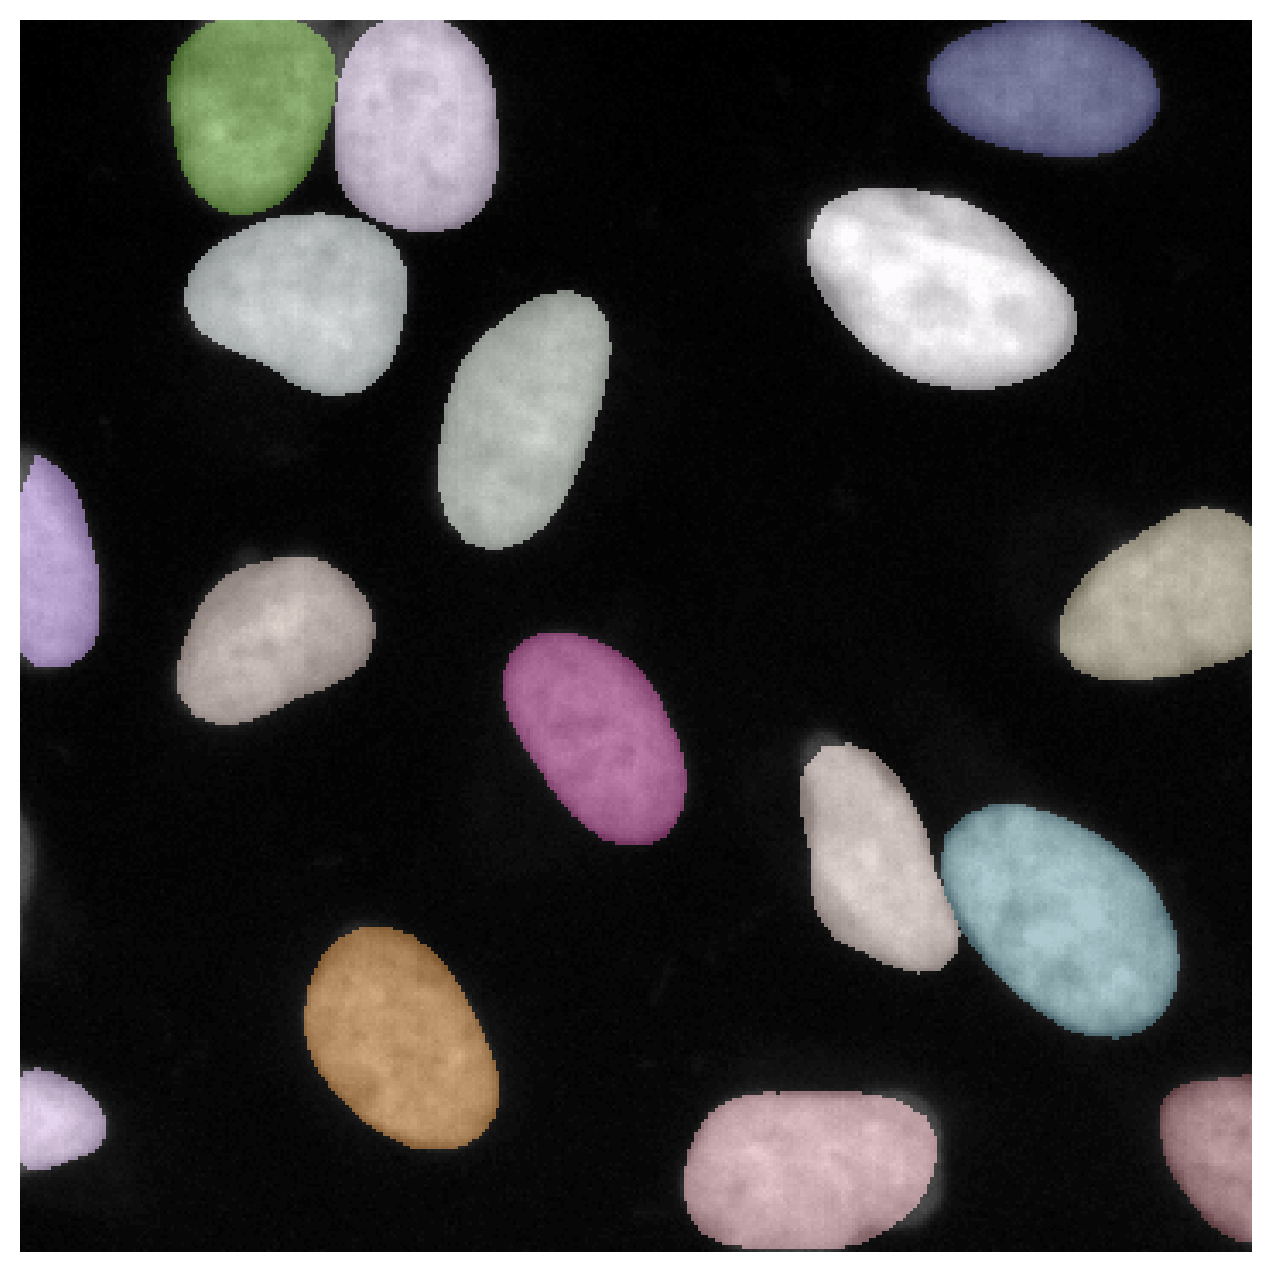

In [8]:
plt.figure(figsize=(8,8))
plt.imshow(img if img.ndim==2 else img[...,0], clim=(0,1), cmap='gray')
plt.imshow(labels, cmap=lbl_cmap, alpha=0.5)
plt.axis('off');

# Example results

In [9]:
def example(model, i, show_dist=True):
    img = normalize(X[i], 1,99.8, axis=axis_norm)
    labels, details = model.predict_instances(img)

    plt.figure(figsize=(13,10))
    img_show = img if img.ndim==2 else img[...,0]
    coord, points, prob = details['coord'], details['points'], details['prob']
    plt.subplot(121); plt.imshow(img_show, cmap='gray'); plt.axis('off')
    a = plt.axis()
    _draw_polygons(coord, points, prob, show_dist=show_dist)
    plt.axis(a)
    plt.subplot(122); plt.imshow(img_show, cmap='gray'); plt.axis('off')
    plt.imshow(labels, cmap=lbl_cmap, alpha=0.5)
    plt.tight_layout()
    plt.show()

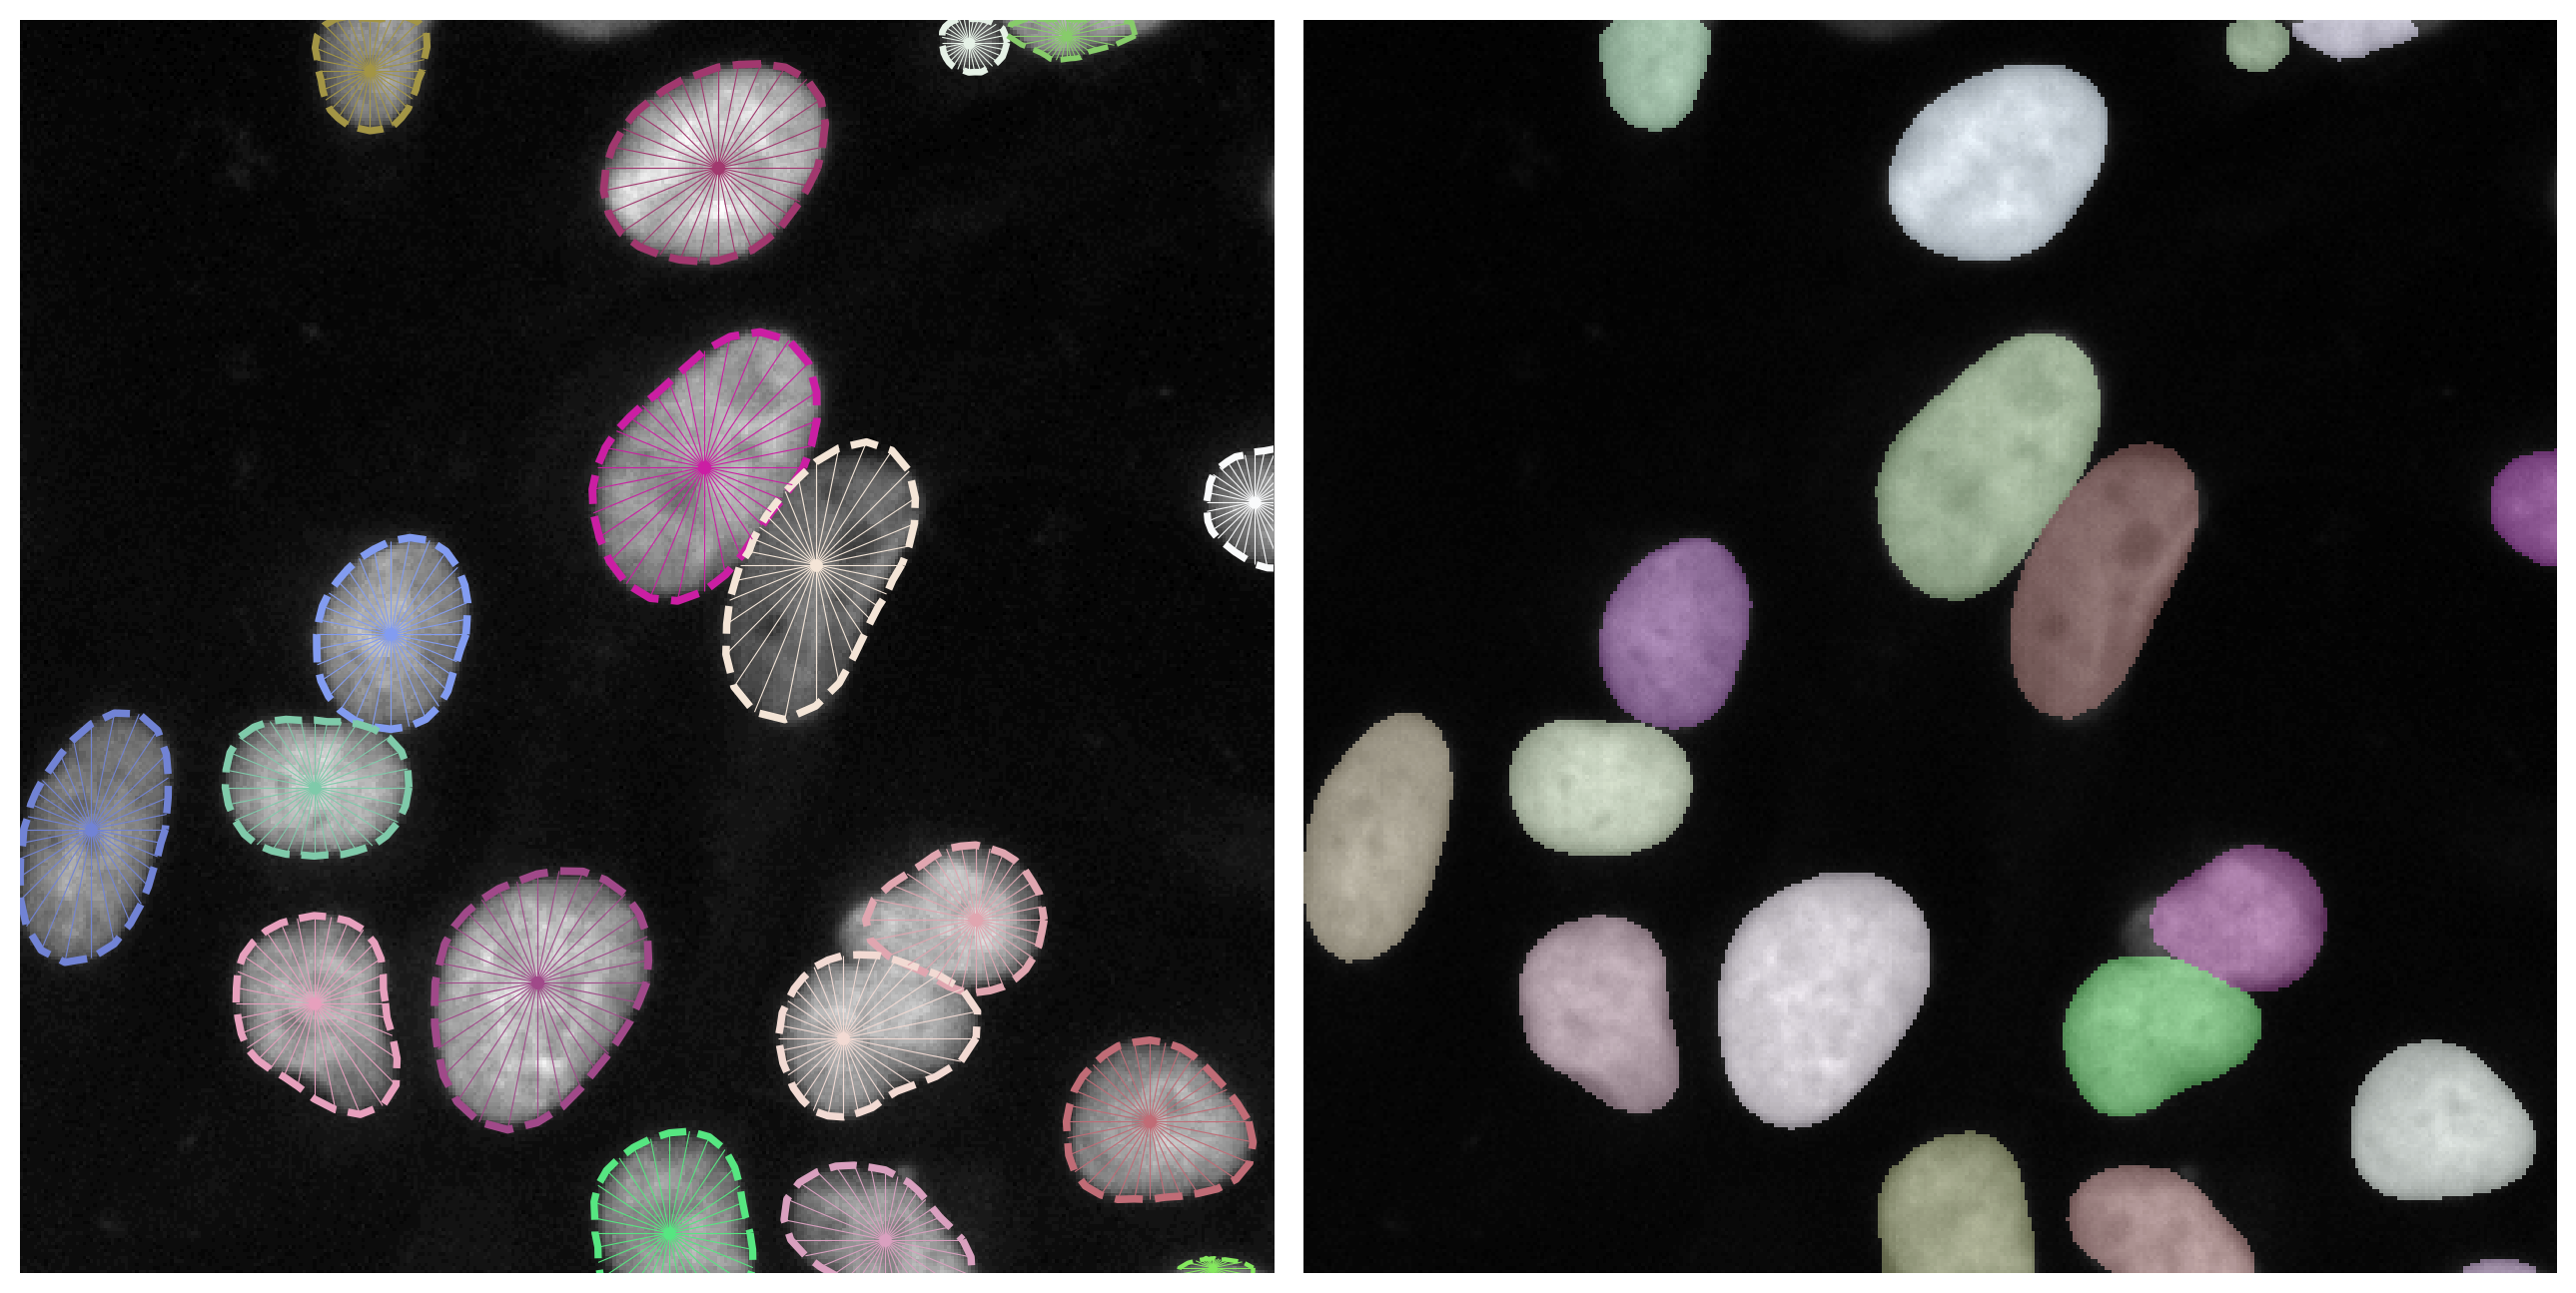

In [10]:
example(model, 42)

## Try with H&E model  -- Intro task!

Show all available pretrained models:

In [11]:
StarDist2D.from_pretrained()

There are 4 registered models for 'StarDist2D':

Name                  Alias(es)
────                  ─────────
'2D_versatile_fluo'   'Versatile (fluorescent nuclei)'
'2D_versatile_he'     'Versatile (H&E nuclei)'
'2D_paper_dsb2018'    'DSB 2018 (from StarDist 2D paper)'
'2D_demo'             None


In [12]:
#add model name here
#model = StarDist2D.from_pretrained('Add_Model_Name_here')
model = StarDist2D.from_pretrained('2D_versatile_he')

Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


In [18]:
##specify path to H&E demo data
path='/nemo/stp/lm/working/fallest/Teaching/Courses_Sept_2024/OnDemand_and_StarDist/StarDist_Course_Sept_2024/Example_Data/HnE_Data'

In [19]:
X = sorted(glob(path+'/*.tif'))  ###add folder name here
file_list = []
for name in X:
    file_list.append(os.path.basename(name))
    
X = list(map(imread,X))

n_channel = 1 if X[0].ndim == 2 else X[0].shape[-1]
axis_norm = (0,1)   # normalize channels independently
# axis_norm = (0,1,2) # normalize channels jointly
if n_channel > 1:
    print("Normalizing image channels %s." % ('jointly' if axis_norm is None or 2 in axis_norm else 'independently'))

Normalizing image channels independently.


In [20]:
file_list  #list the files out that we read in

['TCGA-2Z-A9J9-01A-01-TS1.tif',
 'TCGA-44-2665-01B-06-BS6.tif',
 'TCGA-69-7764-01A-01-TS1.tif',
 'TCGA-A6-6782-01A-01-BS1.tif']

### Normalize a single image and compute the labels

In [21]:
img = normalize(X[3], 1,99.8, axis=axis_norm)
labels, details = model.predict_instances(img)

### Create a function to normazlie images and compute the labels

In [22]:
def example(model, i, show_dist=True):
    img = normalize(X[i], 1,99.8, axis=axis_norm)
    labels, details = model.predict_instances(img)

    plt.figure(figsize=(13,10))
    img_show = img if img.ndim==2 else img[...,0]
    coord, points, prob = details['coord'], details['points'], details['prob']
    plt.subplot(121); plt.imshow(img_show, cmap='gray'); plt.axis('off')
    a = plt.axis()
    _draw_polygons(coord, points, prob, show_dist=show_dist)
    plt.axis(a)
    plt.subplot(122); plt.imshow(img_show, cmap='gray'); plt.axis('off')
    plt.imshow(labels, cmap=lbl_cmap, alpha=0.5)
    plt.tight_layout()
    plt.show()

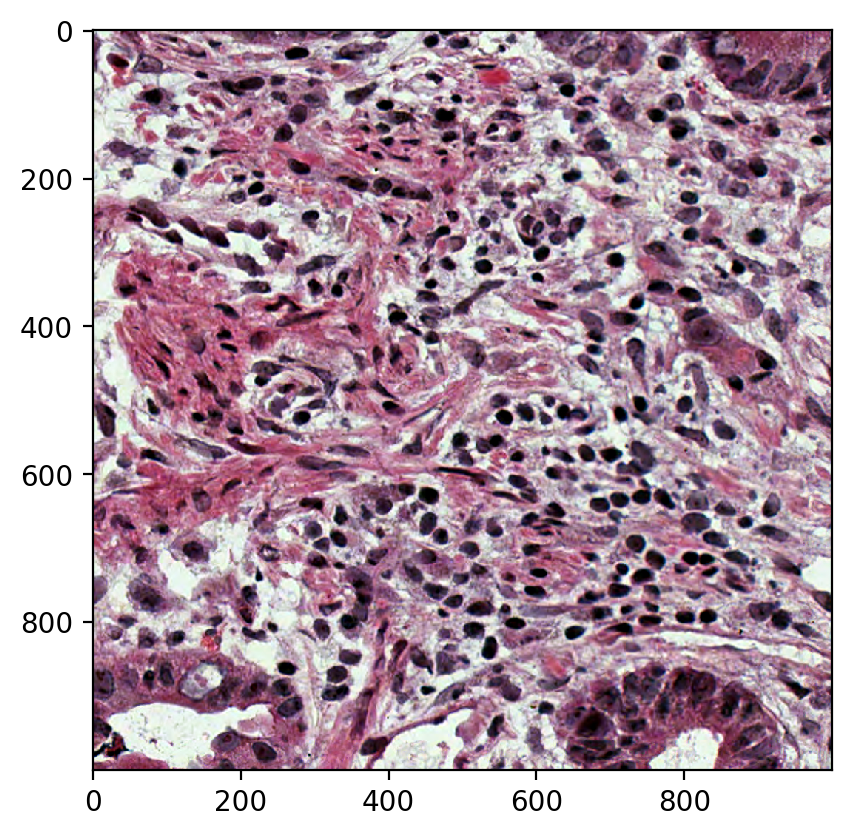

In [23]:
plt.imshow(img)

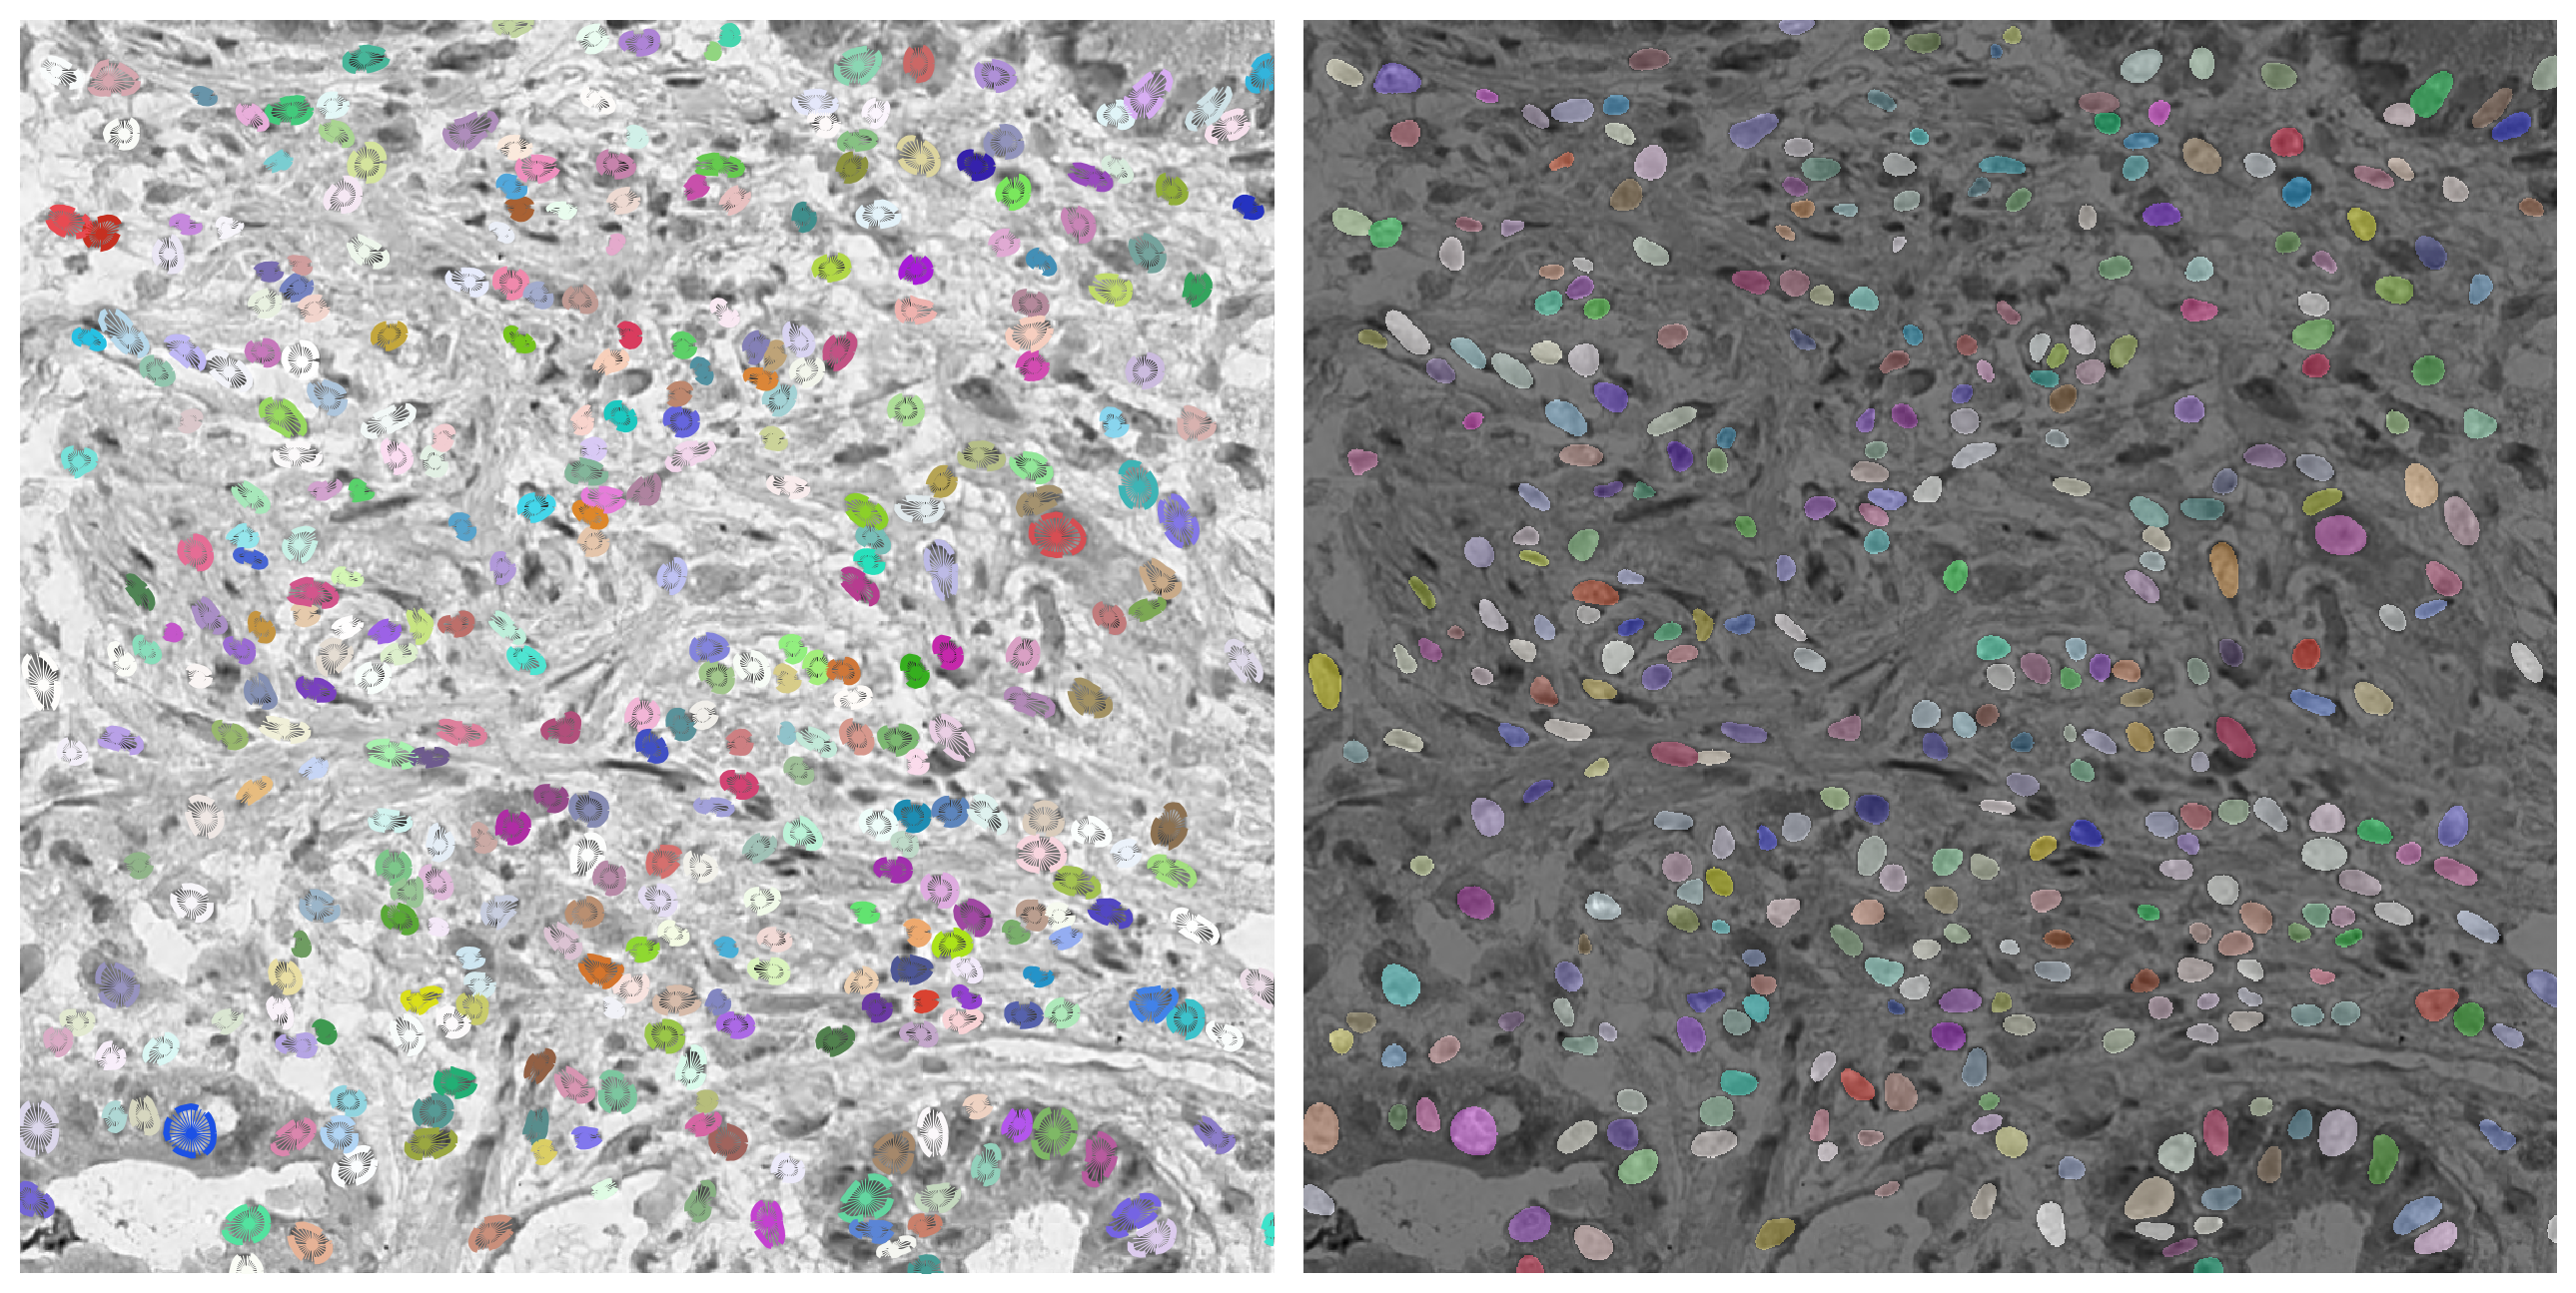

In [24]:
example(model,3)